In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pymongo import MongoClient, DESCENDING

In [33]:
my_client = MongoClient("mongodb://localhost:27017/")
my_db = my_client["goodreads_db"]
my_collection = my_db["books"]

In [34]:
# Retrieve all documents from events collection
documents = my_collection.find()
df = pd.DataFrame(documents).drop("_id", axis=1).drop("ISBN13", axis=1)
df.head()

,Title,Counter,Authors,Avg_Rating,Num_Pages,Ratings_Count,Text_Reviews_Count,Publisher,Publication_Date
0,$30 film school: how to write direct produce...,1,Michael W. Dean,3.49,528,30,4,Cengage Learning,2003-05-13
1,1 000 places to see before you die,1,Patricia Schultz,3.85,992,36303,439,Workman Publishing Company,2003-05-22
2,10 lb penalty,1,Dick Francis,3.90,320,3490,177,G.P. Putnam's Sons,2004-08-03
3,100 great fantasy short short stories,1,Isaac Asimov/Terry Carr/Martin H. Greenberg/Ja...,3.91,395,204,19,Avon,1985-08-01
4,100 love sonnets,1,Pablo Neruda/Stephen Tapscott,4.39,232,12613,392,University of Texas Press,1986-01-01


In [35]:
df["Publication_Date"] = pd.to_datetime(df["Publication_Date"])

print(df.dtypes)

Title                         object
Counter                        int64
Authors                       object
Avg_Rating                   float64
Num_Pages                      int64
Ratings_Count                  int64
Text_Reviews_Count             int64
Publisher                     object
Publication_Date      datetime64[ns]
dtype: object


In [54]:
# Query mongo
pipeline=[
  {
    "$group" :
      {
        "_id" : "$Publisher",
        "total_books" : { "$sum" : 1 },
        "avg": { "$avg" :  "$Avg_Rating" }
      }
  },
  { "$sort" : { "total_books" : -1 } },
  { "$limit" : 5 },
  { "$sort" : { "avg" : -1 } }
]

result=my_collection.aggregate(pipeline)

print("Top 5 Most prolific Publishers sorted on AVG rating")
for doc in result:
  print(doc)

pipeline=[
  {
    "$group" :
      {
        "_id" : "$Authors",
        "total_books" : { "$sum" : 1 },
        "avg": { "$avg" :  "$Avg_Rating" }
      }
  },
  { "$sort" : { "total_books" : -1 } },
  { "$limit" : 5 },
  { "$sort" : { "avg" : -1 } }
]

result=my_collection.aggregate(pipeline)

print("\nTop 5 Most prolific Authors sorted on AVG rating")
for doc in result:
  print(doc)

Top 5 Most prolific Publishers sorted on AVG rating
{'_id': 'Penguin Classics', 'total_books': 177, 'avg': 3.943841807909604}
{'_id': 'Penguin Books', 'total_books': 238, 'avg': 3.9255882352941174}
{'_id': 'Mariner Books', 'total_books': 133, 'avg': 3.9253383458646622}
{'_id': 'Vintage', 'total_books': 281, 'avg': 3.8971530249110318}
{'_id': 'Ballantine Books', 'total_books': 127, 'avg': 3.8696062992125984}

Top 5 Most prolific Authors sorted on AVG rating
{'_id': 'Rumiko Takahashi', 'total_books': 39, 'avg': 4.1866666666666665}
{'_id': 'P.G. Wodehouse', 'total_books': 40, 'avg': 4.14725}
{'_id': 'Agatha Christie', 'total_books': 33, 'avg': 3.989090909090909}
{'_id': 'Stephen King', 'total_books': 40, 'avg': 3.9735}
{'_id': 'Orson Scott Card', 'total_books': 35, 'avg': 3.7791428571428574}


In [37]:
from category_encoders import BinaryEncoder

# Apply Binary Encoding
encoder = BinaryEncoder(cols=['Title', 'Authors', 'Publisher'])
df_encoded = encoder.fit_transform(df)

# Keep only year from date column
df_encoded['Publication_Date'] = (df['Publication_Date']).dt.year

#df_encoded = df_encoded.astype({'Publication_Date':'integer'}, errors='ignore')

df_encoded.rename(columns={"Publication_Date": "Publication_Year"}, inplace=True)

mean_year = df_encoded['Publication_Year'].mean()
df_encoded = df_encoded.fillna({"Publication_Year": mean_year})

df_encoded.head()

#df_enc = pd.DataFrame([titles_vect, df["Counter"], authors_vect, df["Avg_Rating"], df["ISBN13"], df["Num_Pages"], df["Ratings_Count"],df["Text_Reviews_Count"], publishers_vect, df["Publication_Date"]], columns=df.columns)

,Title_0,Title_1,Title_2,Title_3,Title_4,Title_5,Title_6,Title_7,Title_8,Title_9,...,Publisher_3,Publisher_4,Publisher_5,Publisher_6,Publisher_7,Publisher_8,Publisher_9,Publisher_10,Publisher_11,Publication_Year
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2003.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,2003.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,2004.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1985.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,1986.0


<Figure size 640x480 with 0 Axes>

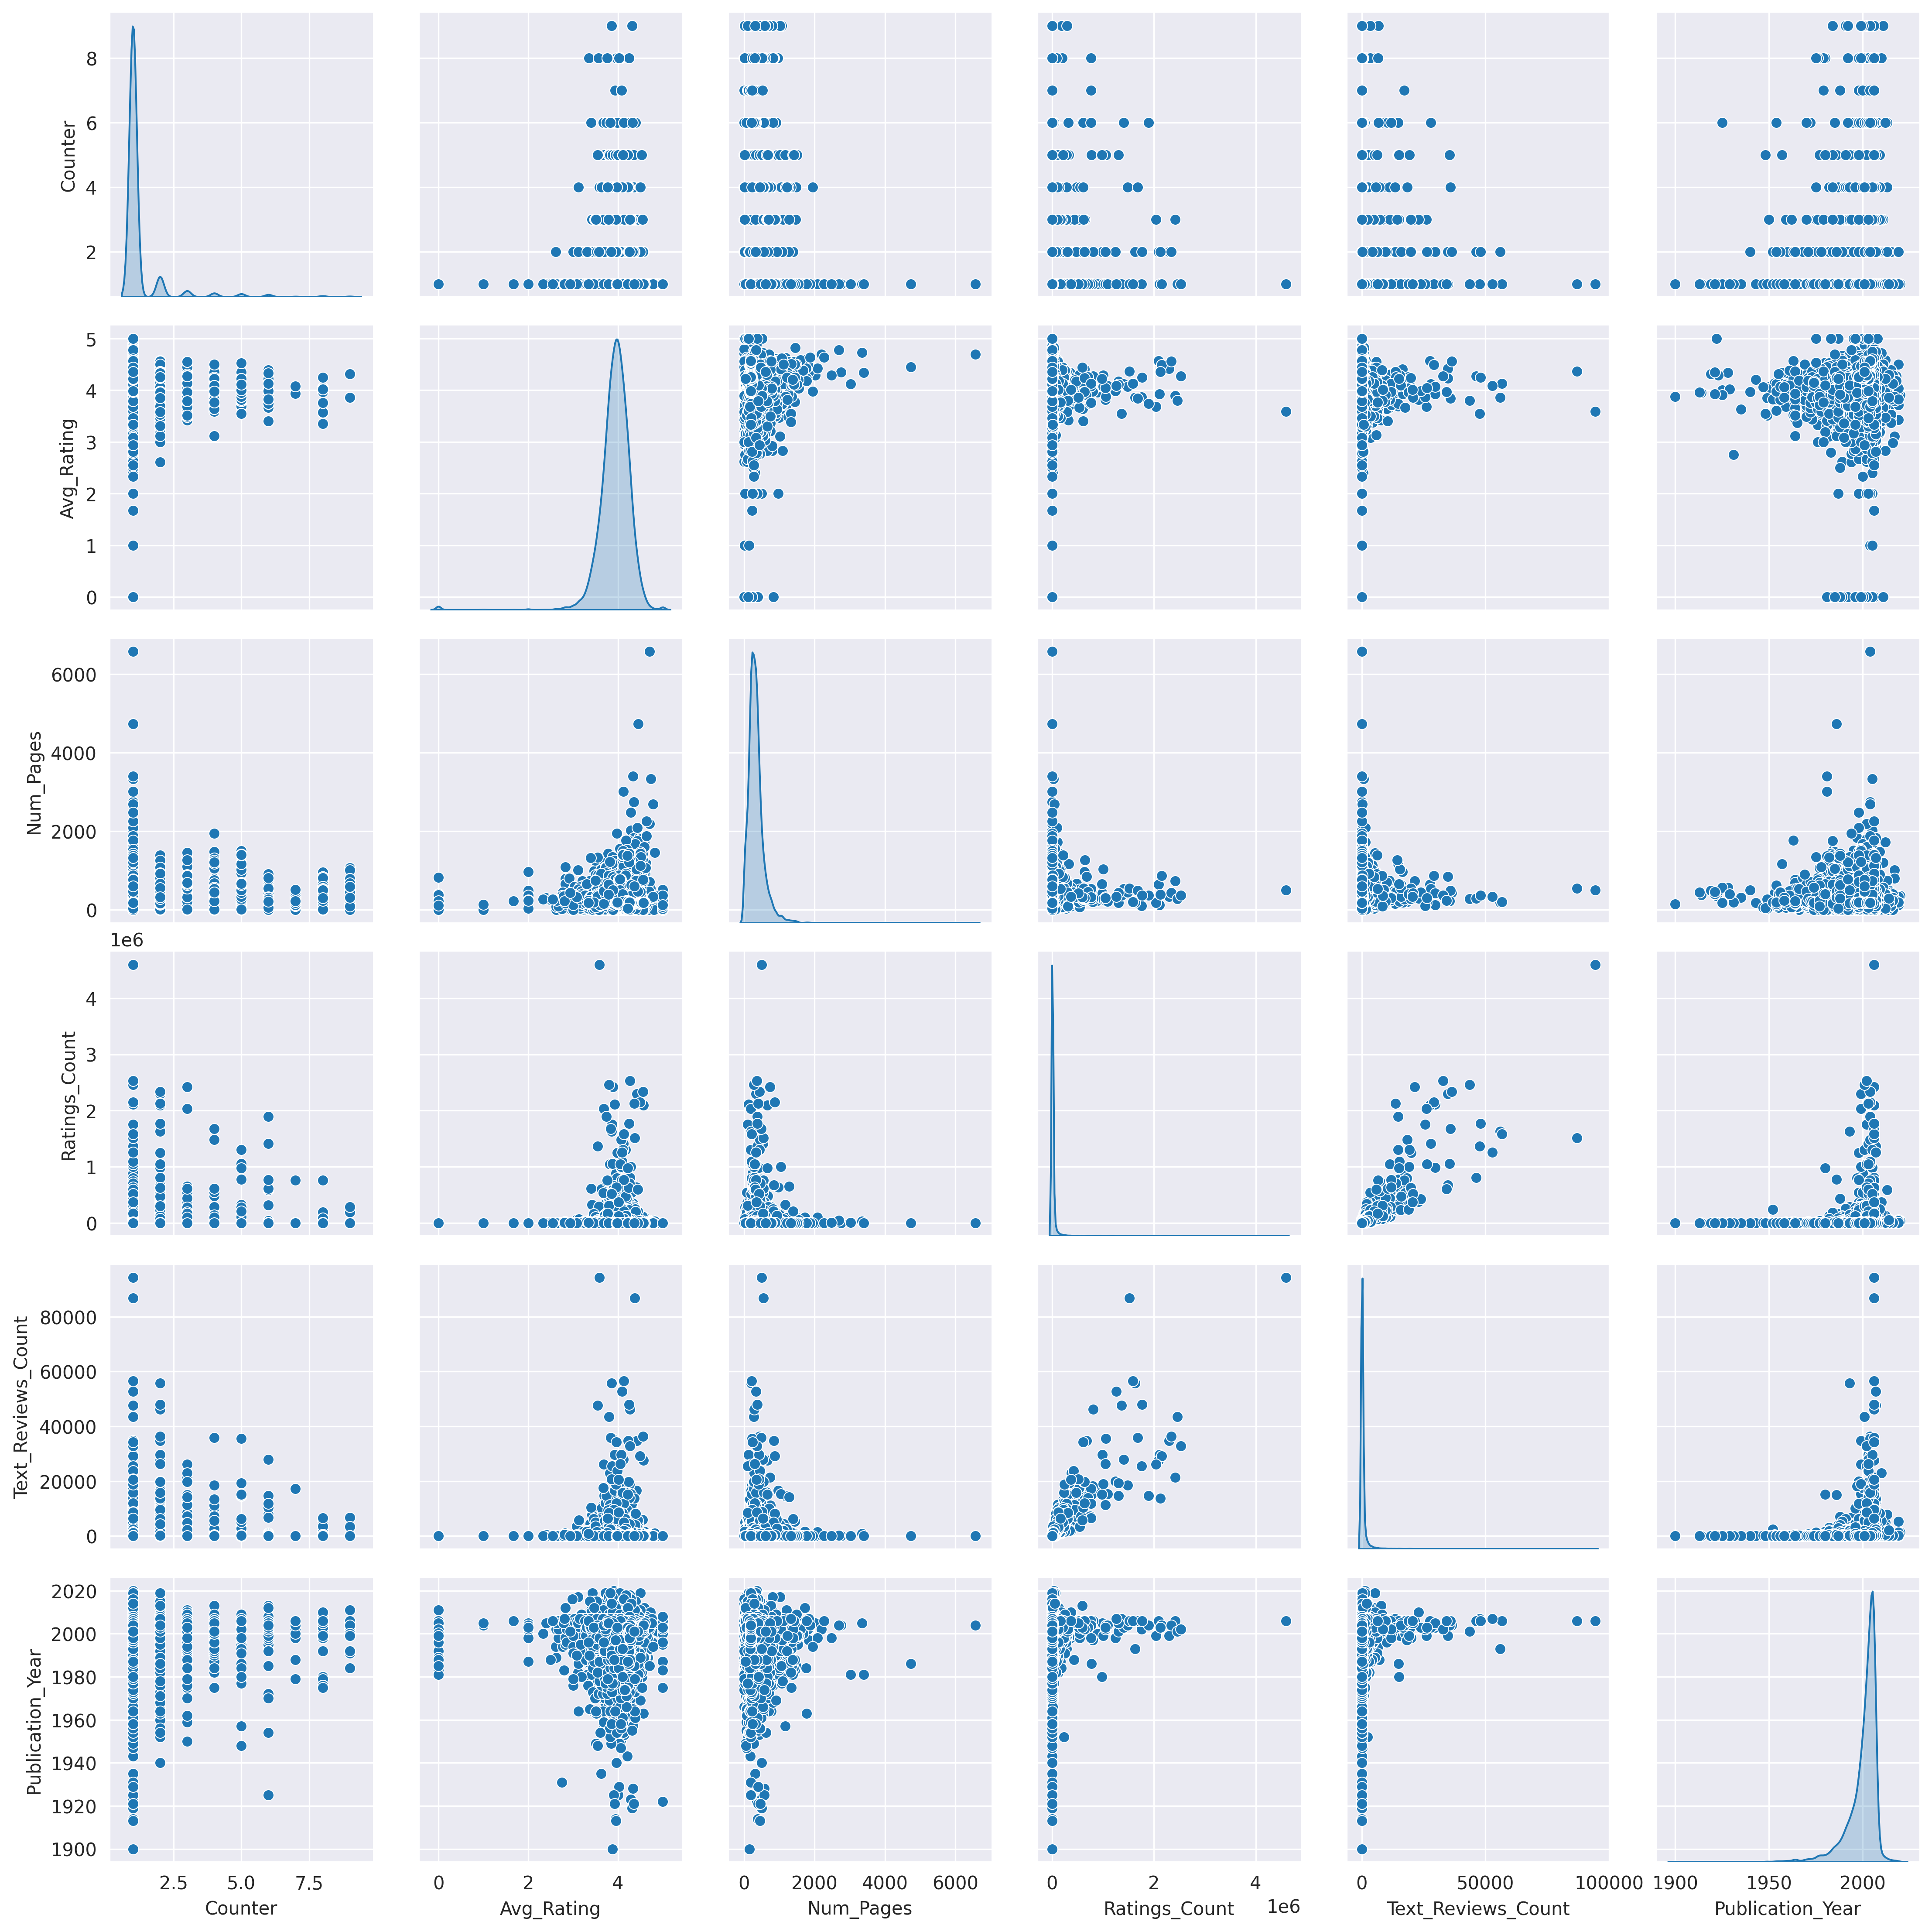

In [38]:
plt.figure()


ax = sns.pairplot(df_encoded[["Counter", "Avg_Rating", "Num_Pages", "Ratings_Count", "Text_Reviews_Count", "Publication_Year"]], diag_kind="kde")
ax.fig.set_dpi(300)

<Axes: >

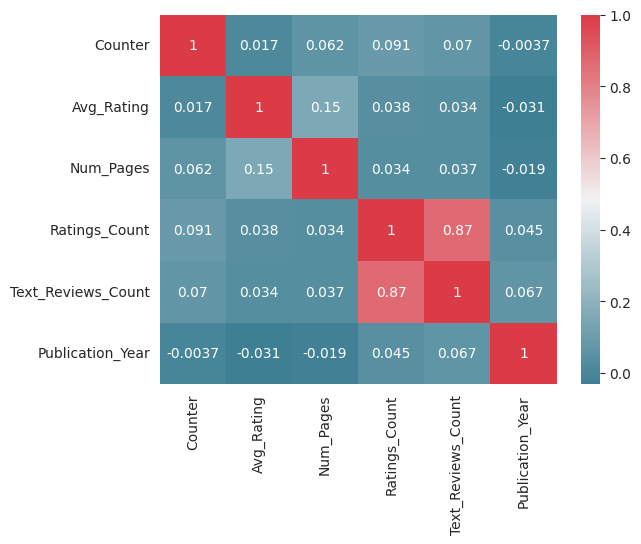

In [39]:
plt.figure()

corr = df_encoded[["Counter", "Avg_Rating", "Num_Pages", "Ratings_Count", "Text_Reviews_Count", "Publication_Year"]].corr()
sns.heatmap(corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True)

In [40]:
from sklearn.model_selection import train_test_split

feature_matrix = df_encoded.loc[:, df_encoded.columns != 'Avg_Rating']
target_vector = df_encoded.Avg_Rating
X_train, X_test, y_train, y_test = train_test_split(feature_matrix, target_vector, test_size=0.2, random_state=1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

X_test.head()

(8901, 44)
(2226, 44)
(8901,)
(2226,)


,Title_0,Title_1,Title_2,Title_3,Title_4,Title_5,Title_6,Title_7,Title_8,Title_9,...,Publisher_3,Publisher_4,Publisher_5,Publisher_6,Publisher_7,Publisher_8,Publisher_9,Publisher_10,Publisher_11,Publication_Year
9914,1,0,0,0,1,1,1,1,0,0,...,0,0,1,1,0,1,1,0,1,2010.0
4437,0,1,0,0,0,0,0,0,1,0,...,0,1,0,0,1,0,0,0,1,2004.0
5140,0,1,0,0,1,0,1,0,1,0,...,0,1,1,0,1,1,1,1,1,1998.0
2617,0,0,1,0,0,1,1,0,0,0,...,0,0,1,1,1,0,0,0,1,2006.0
4804,0,1,0,0,0,1,0,1,1,1,...,0,1,0,0,1,0,0,0,0,2002.0


In [41]:
# Standardization
from sklearn.preprocessing import  StandardScaler


# Creating an object for StandardScaler
sc = StandardScaler()

# Scaling specific columns
X_train[["Counter", "Num_Pages", "Ratings_Count", "Text_Reviews_Count", "Publication_Year"]] = sc.fit_transform(X_train[["Counter", "Num_Pages", "Ratings_Count", "Text_Reviews_Count", "Publication_Year"]])

X_test[["Counter", "Num_Pages", "Ratings_Count", "Text_Reviews_Count", "Publication_Year"]] = sc.transform(X_test[["Counter", "Num_Pages", "Ratings_Count", "Text_Reviews_Count", "Publication_Year"]])

X_test.head()


,Title_0,Title_1,Title_2,Title_3,Title_4,Title_5,Title_6,Title_7,Title_8,Title_9,...,Publisher_3,Publisher_4,Publisher_5,Publisher_6,Publisher_7,Publisher_8,Publisher_9,Publisher_10,Publisher_11,Publication_Year
9914,1,0,0,0,1,1,1,1,0,0,...,0,0,1,1,0,1,1,0,1,1.206589
4437,0,1,0,0,0,0,0,0,1,0,...,0,1,0,0,1,0,0,0,1,0.466594
5140,0,1,0,0,1,0,1,0,1,0,...,0,1,1,0,1,1,1,1,1,-0.273400
2617,0,0,1,0,0,1,1,0,0,0,...,0,0,1,1,1,0,0,0,1,0.713259
4804,0,1,0,0,0,1,0,1,1,1,...,0,1,0,0,1,0,0,0,0,0.219930


In [42]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

model = LinearRegression(fit_intercept=True)
model.fit(X_train, y_train)

R2_base = metrics.r2_score(y_train, model.predict(X_train), sample_weight=None, multioutput='uniform_average')
R2 = metrics.r2_score(y_test, model.predict(X_test), sample_weight=None, multioutput='uniform_average')

print("R2_train: ", R2_base)
print("R2_test: ", R2)

R2_train:  0.03664911916643343
R2_test:  0.027431906730963407


<Axes: >

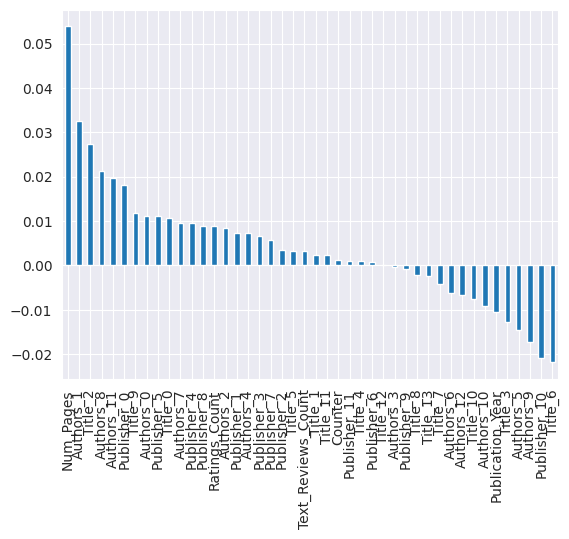

In [43]:
coefficients = pd.Series(model.coef_, index=X_train.columns).sort_values(ascending=False)
coefficients.plot(kind='bar')

In [44]:
import statsmodels.api as sm

X_train_sm = sm.add_constant(X_train)
model_sm = sm.OLS(y_train, X_train_sm).fit()
model_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Avg_Rating   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     7.657
Date:                Fri, 29 Aug 2025   Prob (F-statistic):           9.66e-46
Time:                        11:17:47   Log-Likelihood:                -3116.1
No. Observations:                8901   AIC:                             6322.
Df Residuals:                    8856   BIC:                             6641.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  3.9027      0.021    184.329      0.000       3.861       3.944
Title_0                0.0107      0.014      0.772      0.440      -0.016       0.038
Title_1                0.0023      0.009      0.241      0.809      -0.016       0.021
Title_2                0.0274      0.009      3.097      0.002       0.010       0.045
Title_3               -0.0128      0.007     -1.716      0.086      -0.027       0.002
Title_4                0.0010      0.007      0.129      0.897      -0.014       0.015
Title_5                0.0033      0.007      0.455      0.649      -0.011       0.018
Title_6               -0.0219      0.007     -2.980      0.003      -0.036      -0.007
Title_7               -0.0041      0.007     -0.565      0.572      -0.018       0.010
Title_8               -0.0022      0.007     -0.296      0.767      -0.016       0.012
Title_9                0.0117      0.007      1.600      0.110      -0.003       0.026
Title_10              -0.0076      0.007     -1.044      0.296      -0.022       0.007
Title_11               0.0022      0.007      0.306      0.760      -0.012       0.017
Title_12               0.0001      0.007      0.020      0.984      -0.014       0.014
Title_13              -0.0024      0.007     -0.324      0.746      -0.017       0.012
Counter                0.0012      0.004      0.327      0.744      -0.006       0.008
Authors_0              0.0111      0.011      1.018      0.309      -0.010       0.033
Authors_1              0.0325      0.009      3.780      0.000       0.016       0.049
Authors_2              0.0085      0.008      1.087      0.277      -0.007       0.024
Authors_3             -0.0003      0.007     -0.039      0.969      -0.015       0.014
Authors_4              0.0073      0.007      0.994      0.320      -0.007       0.022
Authors_5             -0.0145      0.007     -1.972      0.049      -0.029   -9.02e-05
Authors_6             -0.0061      0.007     -0.835      0.404      -0.021       0.008
Authors_7              0.0096      0.007      1.314      0.189      -0.005       0.024
Authors_8              0.0213      0.007      2.904      0.004       0.007       0.036
Authors_9             -0.0172      0.007     -2.351      0.019      -0.032      -0.003
Authors_10            -0.0092      0.007     -1.256      0.209      -0.024       0.005
Authors_11             0.0196      0.007      2.680      0.007       0.005       0.034
Authors_12            -0.0067      0.007     -0.918      0.358      -0.021       0.008
Num_Pages              0.0539      0.004     14.537      0.000       0.047       0.061
Ratings_Count          0.0088      0.007      1.206      0.228      -0.005       0.023
Text_Reviews_Count     0.0032      0.007      0.435      0.664      -0.011       0.017
Publisher_0            0.0182      0.0

R2_train:  0.034226940830088703
R2_test:  0.026204263700758346


<Axes: >

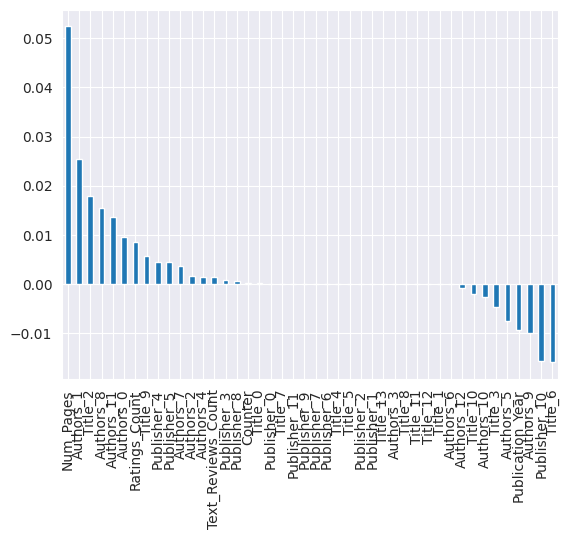

In [45]:
# Lasso
from sklearn.linear_model import LassoCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error

model = LassoCV(fit_intercept=True)
model.fit(X_train, y_train)

R2_base = metrics.r2_score(y_train, model.predict(X_train), sample_weight=None, multioutput='uniform_average')
R2 = metrics.r2_score(y_test, model.predict(X_test), sample_weight=None, multioutput='uniform_average')

print("R2_train: ", R2_base)
print("R2_test: ", R2)

coefficients = pd.Series(model.coef_, index=X_train.columns).sort_values(ascending=False)
coefficients.plot(kind='bar')

In [46]:
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=100, random_state=0, oob_score=True)
regressor.fit(X_train, y_train)

oob_score = regressor.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

predictions = regressor.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

r2 = r2_score(y_test, predictions)
print(f'R2_test: {r2}')

Out-of-Bag Score: 0.1350082985485579
Mean Squared Error: 0.1313091203773585
R2_test: 0.13655129562501866


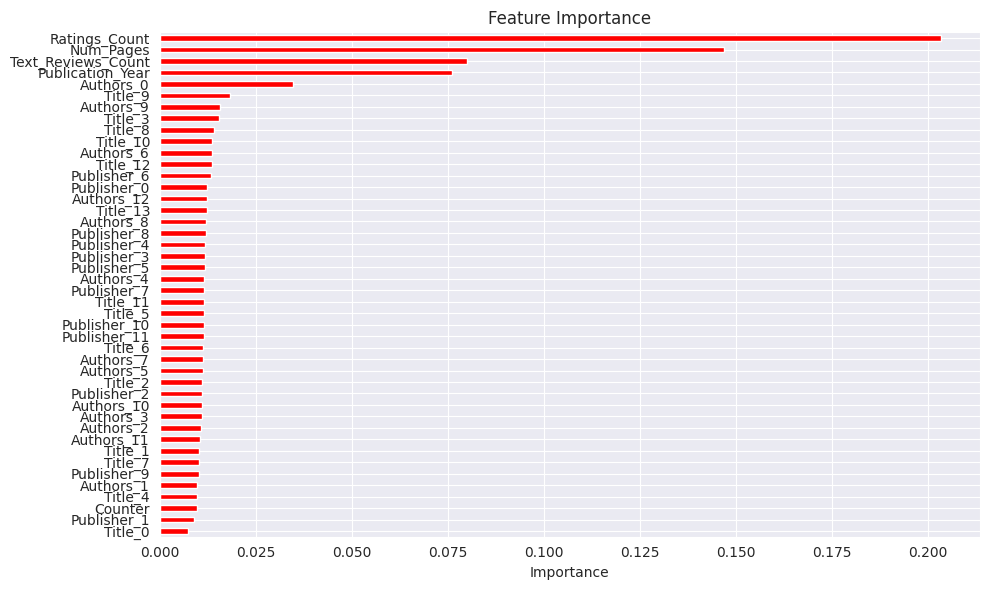

In [47]:
importances = pd.Series(regressor.feature_importances_, index=X_train.columns)
importances.sort_values().plot(kind='barh', figsize=(10, 6), color='r')
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [48]:
from sklearn import ensemble

params = {
    "n_estimators": 600,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
r2 = r2_score(y_test, reg.predict(X_test))
print(f'R2_test: {r2}')

The mean squared error (MSE) on test set: 0.1338
R2_test: 0.12006330157600753


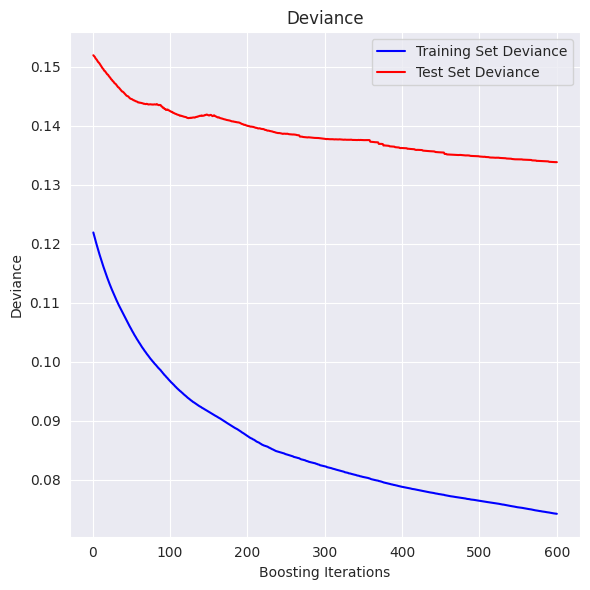

In [49]:
import numpy as np

test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

Text(0.5, 1.0, 'Feature Importance (MDI)')

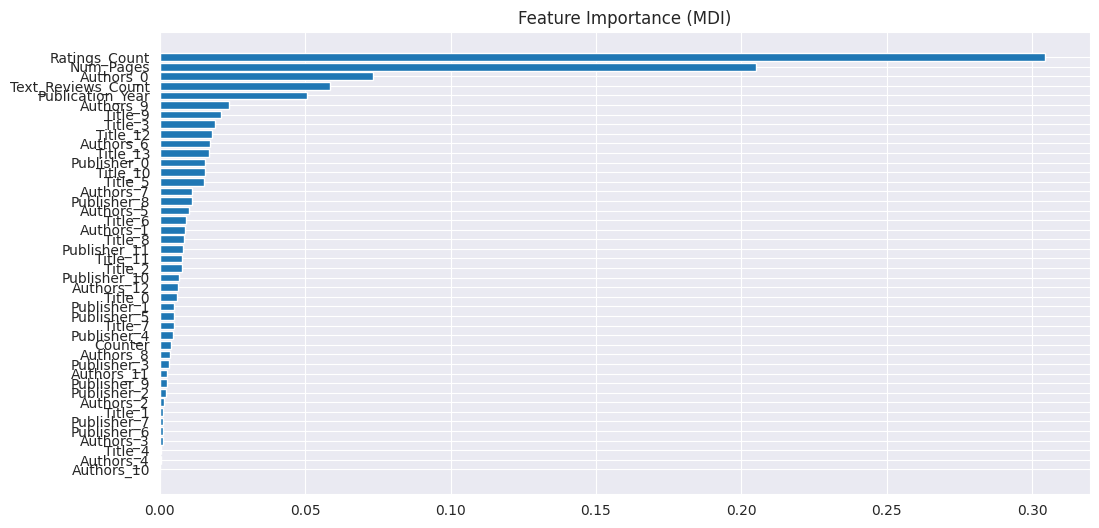

In [50]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(X_train.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")